# Clone and Build GFPGAN and DeOldify Libraries

- We would like to restore old images and videos using Deep Learning. In particular, we will use GFPGAN to upscale images/videos and DeOldify to colorize them.

- We will first start from GFPGAN and then move to DeOldify

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#sample images and videos from Drive
!cp -r '/content/drive/MyDrive/Intro2DeepLearning/group5-a-n/project/sample_images' '/content'
!cp -r '/content/drive/MyDrive/Intro2DeepLearning/group5-a-n/project/video_source' '/content'

In [3]:
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
from moviepy.editor import VideoFileClip, AudioFileClip
import os
import torch
import shutil
import cv2
import tempfile
import numpy as np
from tqdm import tqdm
import glob
import sys
import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

local_device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

- Build **GFPGAN** library from the source

In [4]:
#%%capture
# Clone GFPGAN and enter the GFPGAN folder
%cd /content
!rm -rf GFPGAN
!git clone https://github.com/TencentARC/GFPGAN.git
%cd GFPGAN
# We use BasicSR for both training and inference
!pip install basicsr --quiet
# We use face detection and face restoration helper in the facexlib package
!pip install facexlib --quiet
# Install other depencencies
!pip install -r requirements.txt --quiet
!python setup.py develop
!pip install realesrgan --quiet # used for enhancing the background (non-face) regions
# Download the pre-trained model
# !wget https://github.com/TencentARC/GFPGAN/releases/download/v0.2.0/GFPGANCleanv1-NoCE-C2.pth -P experiments/pretrained_models
#we use the V1.3 model for the demo
!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models

/content
Cloning into 'GFPGAN'...
remote: Enumerating objects: 523, done.
remote: Total 523 (delta 0), reused 0 (delta 0), pack-reused 523
Receiving objects: 100% (523/523), 5.39 MiB | 22.82 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/GFPGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 115.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ***************

In [5]:
#define GFPGAN upscaler
sys.path.append('/content/GFPGAN')
from gfpgan import GFPGANer

from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=2)
bg_upsampler = RealESRGANer(
    scale=2,
    model_path='https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth',
    model=model,
    tile_pad=10,
    pre_pad=0,
    half=True)

model_upscale = GFPGANer(model_path='/content/GFPGAN/experiments/pretrained_models/GFPGANv1.3.pth',device=local_device,bg_upsampler=bg_upsampler)

Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth" to /usr/local/lib/python3.10/dist-packages/weights/RealESRGAN_x2plus.pth



100%|██████████| 64.0M/64.0M [00:03<00:00, 17.3MB/s]


Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth" to /content/GFPGAN/gfpgan/weights/detection_Resnet50_Final.pth



100%|██████████| 104M/104M [00:00<00:00, 213MB/s] 


Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.2.2/parsing_parsenet.pth" to /content/GFPGAN/gfpgan/weights/parsing_parsenet.pth



100%|██████████| 81.4M/81.4M [00:00<00:00, 476MB/s]


- Build **DeOldify** library from the source

In [6]:
# Clone DeOldify
#%%capture
%cd /content
!git clone https://github.com/jantic/DeOldify.git
%cd DeOldify/

!pip install -r requirements-colab.txt --quiet
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

!mkdir 'models'
!wget https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth -O ./models/ColorizeArtistic_gen.pth
# !wget https://data.deepai.org/deoldify/ColorizeVideo_gen.pth -O ./models/ColorizeVideo_gen.pth

sys.path.append('/content/DeOldify')
from deoldify import device
from deoldify.device_id import DeviceId
#choices:  CPU, GPU0...GPU7
device.set(device=DeviceId.GPU0)
import fastai
from deoldify import visualize

/content
Cloning into 'DeOldify'...
remote: Enumerating objects: 2603, done.
remote: Counting objects: 100% (257/257), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 2603 (delta 83), reused 208 (delta 70), pack-reused 2346
Receiving objects: 100% (2603/2603), 69.71 MiB | 16.98 MiB/s, done.
Resolving deltas: 100% (1166/1166), done.
/content/DeOldify
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.4/631.4 kB 59.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 43.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


NumExpr defaulting to 8 threads.


In [7]:
#DeOldify object to be used for colorization
%cd '/content/DeOldify'
colorizer = visualize.get_image_colorizer(artistic=True)
%cd '/content'

/content/DeOldify


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 68.9MB/s]


/content


# Upscale Images with GFPGAN

In [8]:
def image_upscaler(image_dir,restored_dir,save_restored=True):
  # Create the output folder if it does not exist
  if not os.path.exists(restored_dir):
    os.makedirs(restored_dir)

  # Iterate over the images in the input folder
  for filename in os.listdir(image_dir):
      # Read the input image
      input_img = cv2.imread(os.path.join(image_dir, filename), cv2.IMREAD_COLOR)

      # Enhance the input image using the GFPGAN model
      _, _, restored_img = model_upscale.enhance(input_img)

      # Create a 1x2 grid to show original and restored image
      fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

      # Show original image in first subplot
      ax[0].imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
      ax[0].set_title("Original Image")
      ax[0].axis('off')

      # Show restored image in second subplot
      ax[1].imshow(cv2.cvtColor(restored_img, cv2.COLOR_BGR2RGB))
      ax[1].set_title("Restored Image")
      ax[1].axis('off')

      # Adjust the spacing between the subplots
      plt.subplots_adjust(wspace=0.05, hspace=None)

      # Save the restored image to the output folder
      if save_restored:
        cv2.imwrite(os.path.join(restored_dir, filename), restored_img)

      # Save original and restored images side by sid
      ext = filename.split(".")[-1]
      new_name = filename.split(".")[-2] + '_compare.'
      output_path = os.path.join(restored_dir, new_name+ext)
      plt.savefig(output_path, bbox_inches='tight', pad_inches=0)


      # Show the plot
      plt.show()

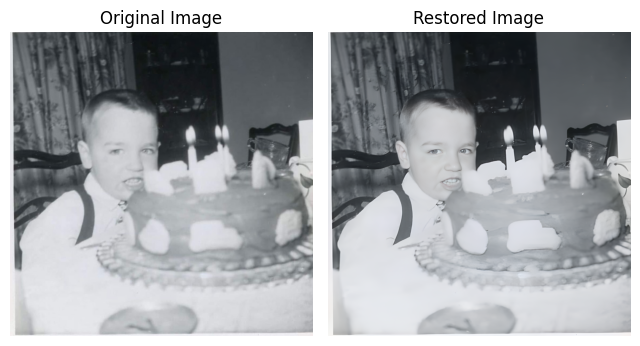

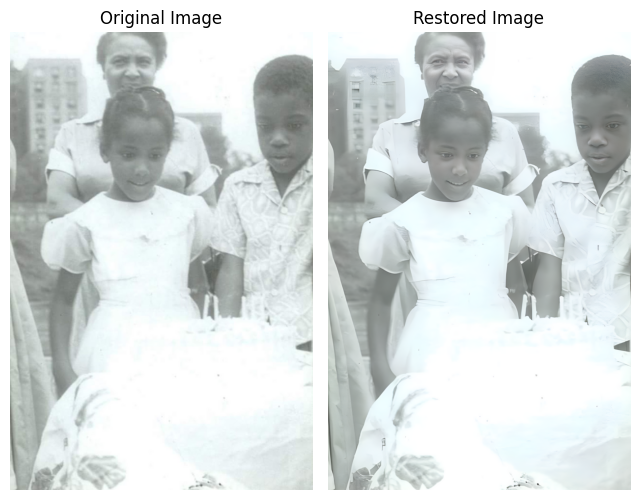

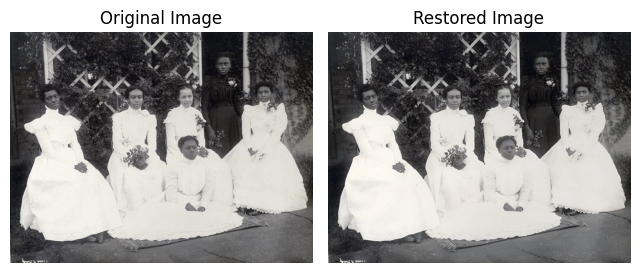

In [9]:
image_upscaler(image_dir='/content/sample_images',
               restored_dir='/content/upscaled_imgs')

# Colorize Images with Deoldify
 

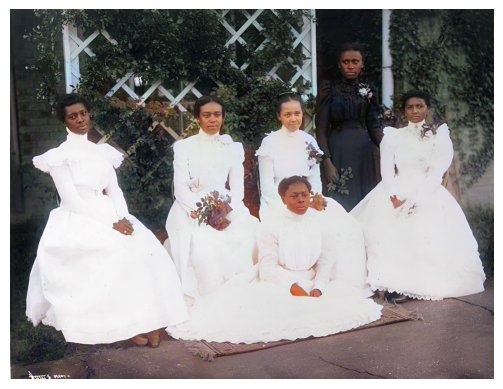

In [10]:
img_path = Path('/content/upscaled_imgs/spelman_students.png')
transformed_image = colorizer.get_transformed_image(img_path, render_factor=15, post_process=True, watermarked=False)
plt.imshow(transformed_image)
plt.axis('off')
plt.show()

In [12]:
#use this function to colorize and plot multiple images. The results will be saved to colorized_dir
def colorize_images(image_dir,colorized_dir,save_colorized=True):
  
  # Create the output folder if it does not exist
  if os.path.exists(colorized_dir):
    shutil.rmtree(colorized_dir)
    os.makedirs(colorized_dir)
  else:
    os.makedirs(colorized_dir)

  # Iterate over the images in the input folder
  for filename in os.listdir(image_dir):
      # Read the input image
      img_path = Path(os.path.join(image_dir, filename))

      # colorize the input image using 
      transformed_image = colorizer.get_transformed_image(img_path, render_factor=15, post_process=True, watermarked=False)

      # Convert the image to a NumPy array in BGR format
      bgr_image = cv2.cvtColor(np.array(transformed_image), cv2.COLOR_RGB2BGR)

      # Create a 1x2 grid to show original and restored image
      fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

      # Show original image in first subplot
      ax[0].imshow(plt.imread(img_path))
      ax[0].set_title("Original Image")
      ax[0].axis('off')

      # Show colorized image in second subplot
      ax[1].imshow(transformed_image)
      ax[1].set_title("Restored Image")
      ax[1].axis('off')

      # Adjust the spacing between the subplots
      plt.subplots_adjust(wspace=0.05, hspace=None)

      # Save the colorized image to the output folder
      if save_colorized:
        cv2.imwrite(os.path.join(colorized_dir, filename), bgr_image)

      # Save original and restored images side by sid
      ext = filename.split(".")[-1]
      new_name = filename.split(".")[-2] + '_compare.'
      output_path = os.path.join(colorized_dir, new_name+ext)
      plt.savefig(output_path, bbox_inches='tight', pad_inches=0)


      # Show the plot
      plt.show()

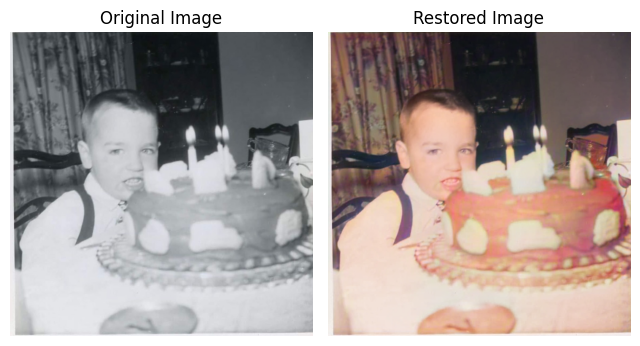

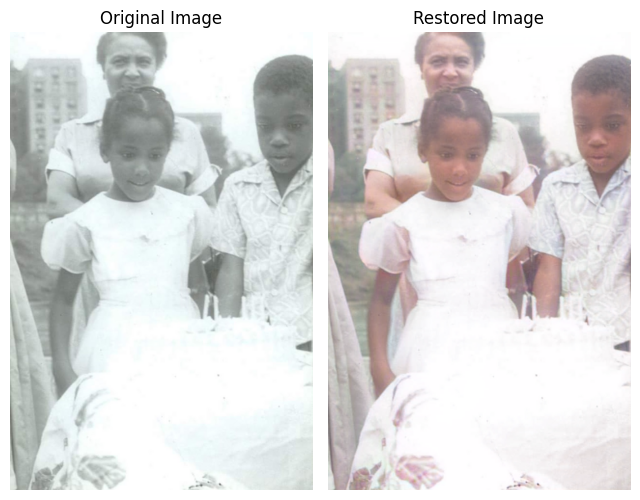

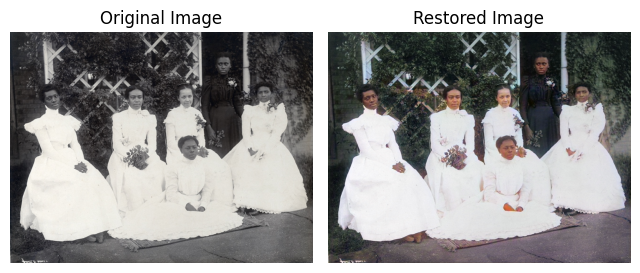

In [13]:
image_dir = '/content/sample_images'
colorized_dir = 'colorized_imgs'
colorize_images(image_dir,colorized_dir)

# Upscale with GFPGAN and Colorize with Deoldify

- In this section, we implement our main goal. First upscale the image using GFPGAN to enhance its quality and then colorize it with Deoldify. This should give us better results.

- With some modification, the very same idea can be applied to videos as well. 

In [14]:
#use this function to upscale and colorize multiple images. Save the results to 'upscaled_colorized_dir' dir
def upscale_colorize_images(image_dir,upscaled_colorized_dir,save_upscaled_colorized=True):
  
  # Create the output folder if it does not exist
  if not os.path.exists(upscaled_colorized_dir):
    os.makedirs(upscaled_colorized_dir)


  # Iterate over the images in the input folder
  for filename in os.listdir(image_dir):
    #read the image
    input_img = cv2.imread(os.path.join(image_dir, filename), cv2.IMREAD_COLOR)
    
    # Enhance the input image using the GFPGAN model
    _, _, restored_img = model_upscale.enhance(input_img)
   
    #save temp upscaled image
    cv2.imwrite('temp.jpg', restored_img)

    # Read the input image
    img_path = Path('temp.jpg')

    # colorize the input image using 
    transformed_image = colorizer.get_transformed_image(img_path, render_factor=15, post_process=True, watermarked=False)

    os.remove('temp.jpg')

    # Convert the image to a NumPy array in BGR format
    bgr_image = cv2.cvtColor(np.array(transformed_image), cv2.COLOR_RGB2BGR)

    # Create a 1x2 grid to show original and restored image
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 12))

    # Show original image in first subplot
    ax[0].imshow(input_img)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    # Show colorized image in second subplot
    ax[1].imshow(transformed_image)
    ax[1].set_title("Restored Image")
    ax[1].axis('off')

    

    # Adjust the spacing between the subplots
    plt.subplots_adjust(wspace=0.05, hspace=None)

    # Save the upscaled_colorized image to the output folder
    if save_upscaled_colorized:
      cv2.imwrite(os.path.join(upscaled_colorized_dir, filename), bgr_image)

    # Save original and restored images side by sid
    ext = filename.split(".")[-1]
    new_name = filename.split(".")[-2] + '_compare.'
    output_path = os.path.join(upscaled_colorized_dir, new_name+ext)
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

    # Show the plot
    plt.show()

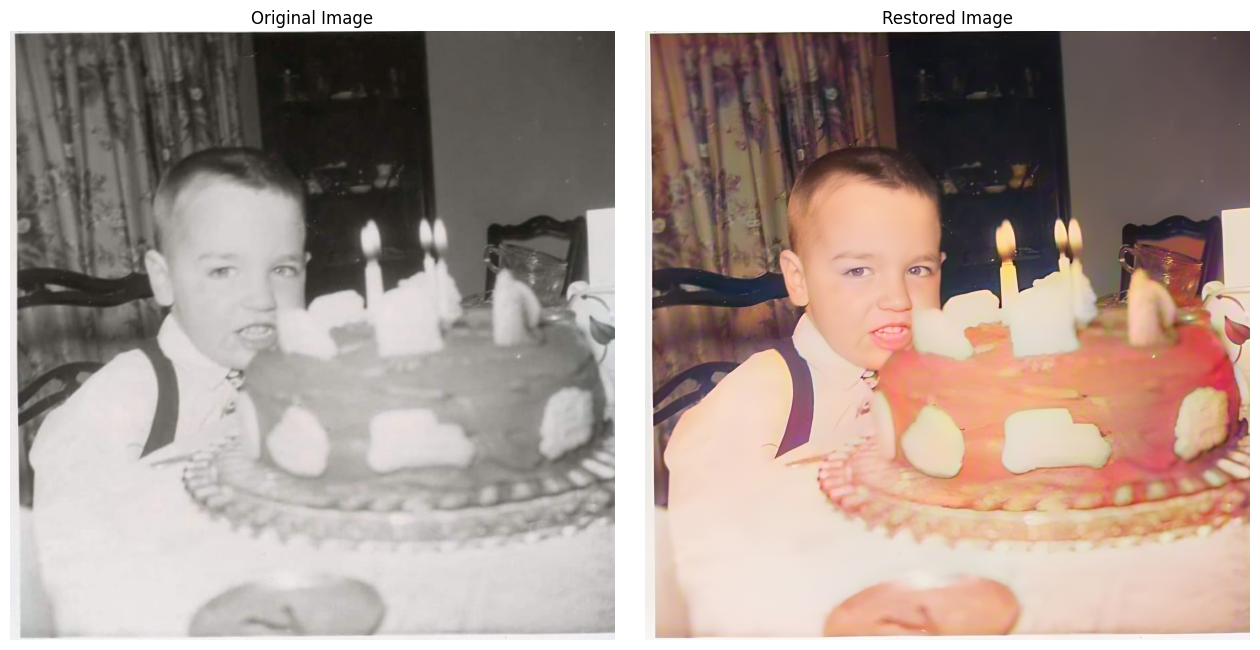

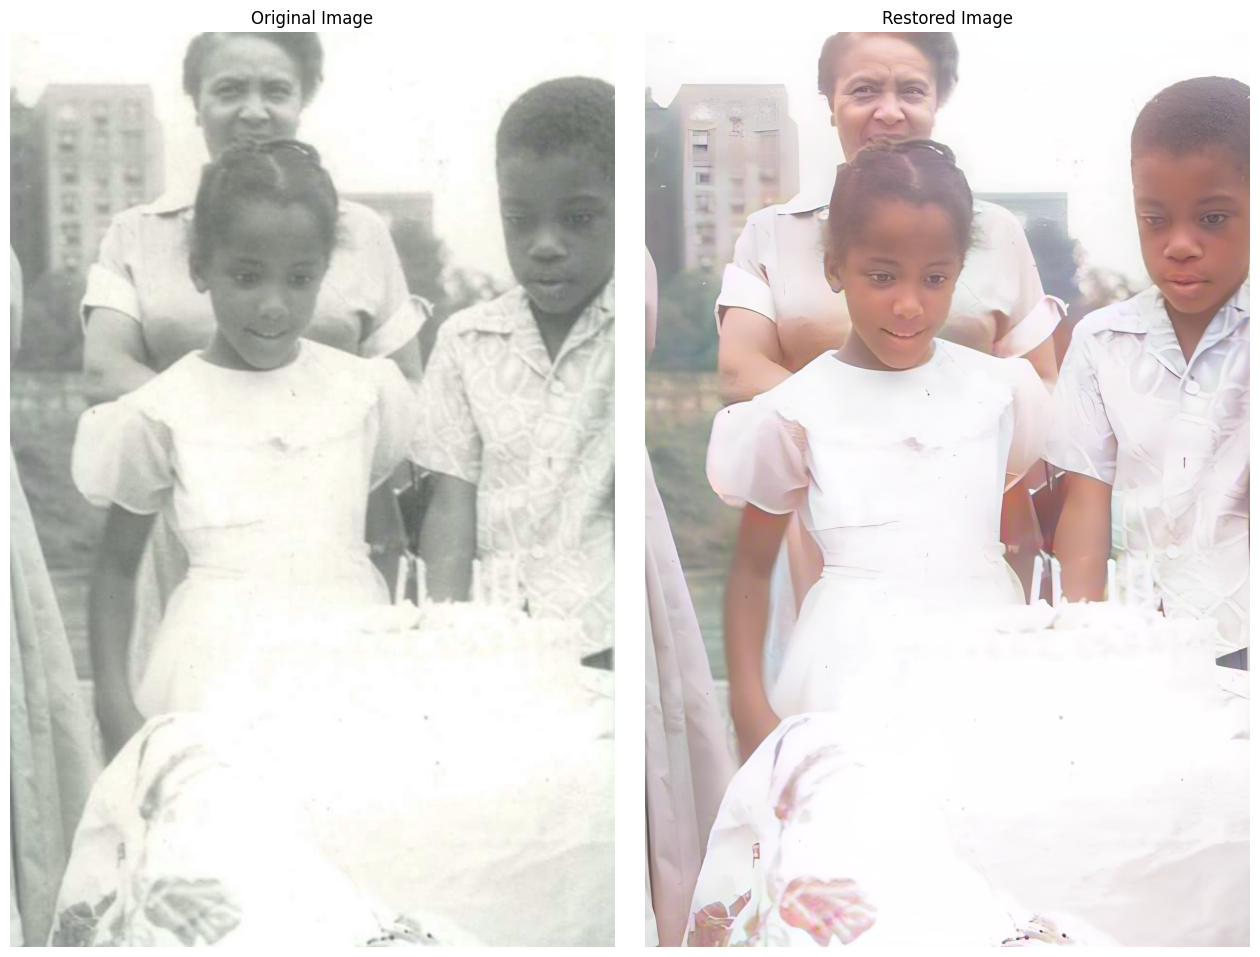

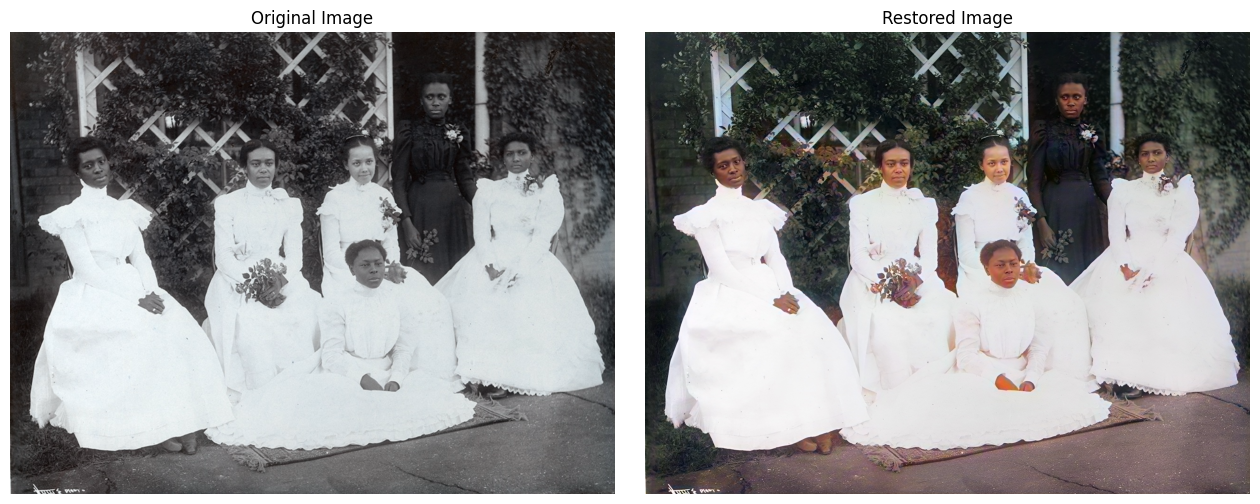

In [15]:
upscale_colorize_images(image_dir='/content/sample_images',
                        upscaled_colorized_dir='upscaled_colorized_imgs',
                        )

- Now our last task is to upscale and colorize videos. This process takes quite time. Thus, we picked a shorter video.

- In *upscale_colorize_video* function you have the option *apply_colorization*. This is relavant becuse if the video is already in colors, we skip colorization, and just upscale it.

In [17]:
def download_folder(folder_list, zip_file_name):
    zip_file_name = zip_file_name+'.zip'
    # Create a ZIP file containing the contents of the source folders
    with zipfile.ZipFile(zip_file_name, "w", zipfile.ZIP_DEFLATED) as zipf:
        for folder in folder_list:
            if os.path.exists(folder) and os.listdir(folder):
                for root, _, filenames in os.walk(folder):
                    for file in filenames:
                        file_path = os.path.join(root, file)
                        zipf.write(file_path, os.path.relpath(file_path, folder))

    # Download the ZIP file
    files.download(zip_file_name)


#create video from saved video frames and add audio. 
def create_video_from_images(input_video_path, output_frames_path, output_video_dir, video_name,fps):
  if not os.path.exists(output_video_dir):
      os.makedirs(output_video_dir)

  img_files = sorted(glob.glob(os.path.join(output_frames_path, "*.png")))
  if not img_files:
      raise ValueError("No images found in the specified folder.")

  # Read the first image to get the dimensions
  img = cv2.imread(img_files[0])
  height, width, _ = img.shape

  # Define the output video properties
  fourcc = cv2.VideoWriter_fourcc(*"MJPG")

  output_video_path = f'{output_video_dir}/temp.avi'
  out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height), isColor=True)

  # Iterate through the sorted image files and write them to the output video
  for img_file in img_files:
      img = cv2.imread(img_file)
      out.write(img)

  # Release the output video object
  out.release()

  # Load the input video and extract its audio track
  input_video = VideoFileClip(input_video_path)
  input_audio = input_video.audio

  # Load the output video without audio
  output_video = VideoFileClip(output_video_path)

  # Add the audio track to the output video
  output_video_with_audio = output_video.set_audio(input_audio)

  # Save the output video with audio
  output_video_with_audio_path = f'{output_video_dir}/{video_name}.mp4'
  output_video_with_audio.write_videofile(output_video_with_audio_path, codec='libx264', audio_codec='aac')

  # Close the video clips to free resources
  input_video.close()
  output_video.close()
  output_video_with_audio.close()

  # Remove the output video without audio
  os.remove(output_video_path)

  print(f'final video saved to {output_video_dir}')
      

- The following function will read a video frame-by-frame, upscale, colorize(if needed) and save as a video. The results will be saved to "output_video_dir" with "video_name". 

- If the video is already colorized but low quality, use "apply_colorization=False" to implement only upscaling. 

In [16]:
def upscale_colorize_video(input_video_path, output_video_dir, video_name, apply_colorization = True):
  
  cap = cv2.VideoCapture(input_video_path)

  # Get the input video properties
  total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = int(cap.get(cv2.CAP_PROP_FPS))

  output_frames_path = 'output_frames_path'
  # Remove the output_frames_path directory if it exists
  if os.path.exists(output_frames_path):
      shutil.rmtree(output_frames_path)

  # Create the output_frames_path directory
  os.makedirs(output_frames_path)

  pbar = tqdm(total=total_frames, desc="Processing video")

  frame_id = 0
  try:
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frame_id += 1
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            _, _, restored_img = model_upscale.enhance(frame_rgb)
            restored_img_pil = Image.fromarray(restored_img)

            if apply_colorization:
                with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as temp_file:
                    restored_img_pil.save(temp_file.name)
                    temp_file_path = Path(temp_file.name)
                    transformed_image = colorizer.get_transformed_image(temp_file_path, render_factor=15, post_process=True, watermarked=False)
                    transformed_image_bgr = cv2.cvtColor(np.array(transformed_image), cv2.COLOR_RGB2BGR)
                    transformed_image.close()
                    temp_file_path.unlink()
            else:
                transformed_image_bgr = cv2.cvtColor(restored_img, cv2.COLOR_RGB2BGR)

            transformed_image_path = Path(f'{output_frames_path}/frame_{frame_id:05d}.png')
            transformed_image_path.parent.mkdir(parents=True, exist_ok=True)
            cv2.imwrite(str(transformed_image_path), transformed_image_bgr)

            pbar.update(1)
        else:
          print(f"\nframe_id:{frame_id} is broken, skipping")
          break
  except KeyboardInterrupt:
    print("\nVideo processing interrupted.")
  finally:
    cap.release()
    pbar.close()
  
    #create a video from saved frames and add audio
    create_video_from_images(input_video_path, output_frames_path, output_video_dir, video_name,fps)
    #remove "output_frames_path" as we dont need it.
    shutil.rmtree(output_frames_path)
      


- Once the conversion is over, make sure to drag and drop the video file from "upscaled_videos" folders to your Google drive. It is not always possible to play videos in Jupyter notebook.

- Alternatively, you can use download_folder function to download the necessary folders to avoid losing them when the Colab is inturrupted. 

In [18]:
input_video_path = '/content/video_source/hawai-orchastra-short.mp4'
output_video_dir = 'upscaled_videos'
video_name = 'hawai'
apply_colorization = True
upscale_colorize_video(input_video_path, output_video_dir, video_name, apply_colorization = apply_colorization)


Processing video: 100%|██████████| 87/87 [00:22<00:00,  3.81it/s]



frame_id:87 is broken, skipping
Moviepy - Building video upscaled_videos/hawai.mp4.
MoviePy - Writing audio in hawaiTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video upscaled_videos/hawai.mp4



Moviepy - Done !
Moviepy - video ready upscaled_videos/hawai.mp4
final video saved to upscaled_videos



- The best idea is to download from upscaled_videos/hawai.mp4 and watch the video locally but for short videos, you can use the following script

In [19]:
from IPython.display import HTML
from base64 import b64encode

!ffmpeg -i /content/upscaled_videos/hawai.mp4 -vf fps=30 -vcodec libx264 output.mp4

mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

#display the video
HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [20]:
#download upscaled videos and upscaled images if you want to save them locally
download = False
if download:
  folder_list = ['/content/upscaled_videos','/content/upscaled_imgs','/content/upscaled_colorized_imgs','/content/colorized_imgs']
  zip_file_name = 'upscaled_items'
  download_folder(folder_list,zip_file_name)